In [1]:
import tensorflow as tf
import os
from PIL import Image

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
tf.__version__

'2.5.0-rc1'

In [22]:
base = "../data/data_dir/"
images = os.listdir(os.path.join(base,"Images/"))
masks = os.listdir(os.path.join(base, "Masks/"))
images.sort()
masks.sort()
images = images[1:]
masks = masks[1:]

In [23]:
def image_example(image_string, label_string):
    image_shape = tf.image.decode_png(image_string, channels=3).shape
    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"png"])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[image_shape[0]])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[image_shape[1]])),
        #'image/channels': tf.train.Feature(int64_list=tf.train.Int64List(value=[3])),
        'image/segmentation/class/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[label_string])),
        'image/segmentation/class/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"png"])),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [24]:
record_file = 'trainseg.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for image, mask in zip(images, masks):
        img = tf.io.gfile.GFile(os.path.join(base,"Images/",image), 'rb').read()
        msk = tf.io.gfile.GFile(os.path.join(base,"Masks/",mask), 'rb').read()
        example = image_example(img, msk)
        writer.write(example.SerializeToString())
!du -sh {record_file}

 45M	trainseg.tfrecords


In [38]:
def _parse_function(example_proto):
    """Function to parse the example proto.

    Args:
      example_proto: Proto in the format of tf.Example.

    Returns:
      A dictionary with parsed image, label, height, width and image name.

    Raises:
      ValueError: Label is of wrong shape.
    """

    # Currently only supports jpeg and png.
    # Need to use this logic because the shape is not known for
    # tf.image.decode_image and we rely on this info to
    # extend label if necessary.
    def _decode_image(content, channels):
      return tf.cond(
          tf.image.is_jpeg(content),
          lambda: tf.image.decode_jpeg(content, channels),
          lambda: tf.image.decode_png(content, channels))

    features = {
        'image/encoded':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/filename':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/format':
            tf.io.FixedLenFeature((), tf.string, default_value='png'),
        'image/height':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/width':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/segmentation/class/encoded':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/segmentation/class/format':
            tf.io.FixedLenFeature((), tf.string, default_value='png'),
    }

    parsed_features = tf.io.parse_single_example(example_proto, features)
    #image = Image.open(BytesIO(parsed_features['image/encoded']))
    #print(image.shape)
    image = tf.io.decode_png(parsed_features['image/encoded'])
    print("hi")
    return image

In [39]:
raw_image_dataset = tf.data.TFRecordDataset('trainseg.tfrecords')

In [41]:
a = raw_image_dataset.map(_parse_function)
for x in a:
    #print(x)
    1+1

hi


In [100]:
from io import BytesIO
import tensorflow.compat.v1 as tf1

<class 'tensorflow.python.framework.ops.EagerTensor'>


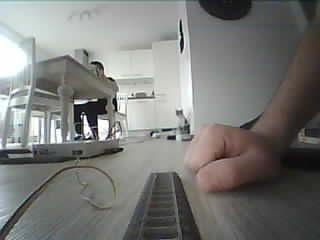

In [75]:
im = next(iter(a))
print(type(im))
bio = BytesIO(im.numpy())
Image.open(bio)

In [43]:
import tensorflow as tf 
raw_dataset = tf.data.TFRecordDataset("trainseg.tfrecords")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

In [ ]:
PYTHONPATH=.:./slim python3.7 deeplab/train.py \
    --logtostderr \
    --training_number_of_steps=30000 \
    --train_split="train" \
    --model_variant="xception_65" \
    --atrous_rates=6 \
    --atrous_rates=12 \
    --atrous_rates=18 \
    --output_stride=16 \
    --decoder_output_stride=4 \
    --train_crop_size=513 \
    --train_crop_size=513 \
    --train_batch_size=1 \
    --dataset="trainseg" \
    --tf_initial_checkpoint=${PATH_TO_INITIAL_CHECKPOINT} \
    --train_logdir=/home/ubuntuadm/trainseg/train_log \
    --dataset_dir=/home/ubuntuadm/trainseg/data/

In [ ]:
0: input_3
1: conv1_pad
2: conv1
3: bn_conv1
4: activation
5: pool1_pad
6: max_pooling2d
7: res2a_branch2a
8: bn2a_branch2a
9: activation_1
10: res2a_branch2b
11: bn2a_branch2b
12: activation_2
13: res2a_branch2c
14: res2a_branch1
15: bn2a_branch2c
16: bn2a_branch1
17: add
18: activation_3
19: res2b_branch2a
20: bn2b_branch2a
21: activation_4
22: res2b_branch2b
23: bn2b_branch2b
24: activation_5
25: res2b_branch2c
26: bn2b_branch2c
27: add_1
28: activation_6
29: res2c_branch2a
30: bn2c_branch2a
31: activation_7
32: res2c_branch2b
33: bn2c_branch2b
34: activation_8
35: res2c_branch2c
36: bn2c_branch2c
37: add_2
38: activation_9
39: res3a_branch2a
40: bn3a_branch2a
41: activation_10
42: res3a_branch2b
43: bn3a_branch2b
44: activation_11
45: res3a_branch2c
46: res3a_branch1
47: bn3a_branch2c
48: bn3a_branch1
49: add_3
50: activation_12
51: res3b_branch2a
52: bn3b_branch2a
53: activation_13
54: res3b_branch2b
55: bn3b_branch2b
56: activation_14
57: res3b_branch2c
58: bn3b_branch2c
59: add_4
60: activation_15
61: res3c_branch2a
62: bn3c_branch2a
63: activation_16
64: res3c_branch2b
65: bn3c_branch2b
66: activation_17
67: res3c_branch2c
68: bn3c_branch2c
69: add_5
70: activation_18
71: res3d_branch2a
72: bn3d_branch2a
73: activation_19
74: res3d_branch2b
75: bn3d_branch2b
76: activation_20
77: res3d_branch2c
78: bn3d_branch2c
79: add_6
80: activation_21
81: res4a_branch2a
82: bn4a_branch2a
83: activation_22
84: res4a_branch2b
85: bn4a_branch2b
86: activation_23
87: res4a_branch2c
88: res4a_branch1
89: bn4a_branch2c
90: bn4a_branch1
91: add_7
92: activation_24
93: res4b_branch2a
94: bn4b_branch2a
95: activation_25
96: res4b_branch2b
97: bn4b_branch2b
98: activation_26
99: res4b_branch2c
100: bn4b_branch2c
101: add_8
102: activation_27
103: res4c_branch2a
104: bn4c_branch2a
105: activation_28
106: res4c_branch2b
107: bn4c_branch2b
108: activation_29
109: res4c_branch2c
110: bn4c_branch2c
111: add_9
112: activation_30
113: res4d_branch2a
114: bn4d_branch2a
115: activation_31
116: res4d_branch2b
117: bn4d_branch2b
118: activation_32
119: res4d_branch2c
120: bn4d_branch2c
121: add_10
122: activation_33
123: res4e_branch2a
124: bn4e_branch2a
125: activation_34
126: res4e_branch2b
127: bn4e_branch2b
128: activation_35
129: res4e_branch2c
130: bn4e_branch2c
131: add_11
132: activation_36
133: res4f_branch2a
134: bn4f_branch2a
135: activation_37
136: res4f_branch2b
137: bn4f_branch2b
138: activation_38
139: res4f_branch2c
140: bn4f_branch2c
141: add_12
142: activation_39
143: res5a_branch2a
144: bn5a_branch2a
145: activation_40
146: res5a_branch2b
147: bn5a_branch2b
148: activation_41
149: res5a_branch2c
150: res5a_branch1
151: bn5a_branch2c
152: bn5a_branch1
153: add_13
154: activation_42
155: res5b_branch2a
156: bn5b_branch2a
157: activation_43
158: res5b_branch2b
159: bn5b_branch2b
160: activation_44
161: res5b_branch2c
162: bn5b_branch2c
163: add_14
164: activation_45
165: res5c_branch2a
166: bn5c_branch2a
167: activation_46
168: res5c_branch2b
169: bn5c_branch2b
170: activation_47
171: res5c_branch2c
172: bn5c_branch2c
173: add_15
174: activation_48

In [ ]:
0: input_3
1: conv1_pad
2: conv1_conv
3: conv1_bn
4: conv1_relu
5: pool1_pad
6: pool1_pool
7: conv2_block1_1_conv
8: conv2_block1_1_bn
9: conv2_block1_1_relu
10: conv2_block1_2_conv
11: conv2_block1_2_bn
12: conv2_block1_2_relu
13: conv2_block1_0_conv
14: conv2_block1_3_conv
15: conv2_block1_0_bn
16: conv2_block1_3_bn
17: conv2_block1_add
18: conv2_block1_out
19: conv2_block2_1_conv
20: conv2_block2_1_bn
21: conv2_block2_1_relu
22: conv2_block2_2_conv
23: conv2_block2_2_bn
24: conv2_block2_2_relu
25: conv2_block2_3_conv
26: conv2_block2_3_bn
27: conv2_block2_add
28: conv2_block2_out
29: conv2_block3_1_conv
30: conv2_block3_1_bn
31: conv2_block3_1_relu
32: conv2_block3_2_conv
33: conv2_block3_2_bn
34: conv2_block3_2_relu
35: conv2_block3_3_conv
36: conv2_block3_3_bn
37: conv2_block3_add
38: conv2_block3_out
39: conv3_block1_1_conv
40: conv3_block1_1_bn
41: conv3_block1_1_relu
42: conv3_block1_2_conv
43: conv3_block1_2_bn
44: conv3_block1_2_relu
45: conv3_block1_0_conv
46: conv3_block1_3_conv
47: conv3_block1_0_bn
48: conv3_block1_3_bn
49: conv3_block1_add
50: conv3_block1_out
51: conv3_block2_1_conv
52: conv3_block2_1_bn
53: conv3_block2_1_relu
54: conv3_block2_2_conv
55: conv3_block2_2_bn
56: conv3_block2_2_relu
57: conv3_block2_3_conv
58: conv3_block2_3_bn
59: conv3_block2_add
60: conv3_block2_out
61: conv3_block3_1_conv
62: conv3_block3_1_bn
63: conv3_block3_1_relu
64: conv3_block3_2_conv
65: conv3_block3_2_bn
66: conv3_block3_2_relu
67: conv3_block3_3_conv
68: conv3_block3_3_bn
69: conv3_block3_add
70: conv3_block3_out
71: conv3_block4_1_conv
72: conv3_block4_1_bn
73: conv3_block4_1_relu
74: conv3_block4_2_conv
75: conv3_block4_2_bn
76: conv3_block4_2_relu
77: conv3_block4_3_conv
78: conv3_block4_3_bn
79: conv3_block4_add
80: conv3_block4_out
81: conv4_block1_1_conv
82: conv4_block1_1_bn
83: conv4_block1_1_relu
84: conv4_block1_2_conv
85: conv4_block1_2_bn
86: conv4_block1_2_relu
87: conv4_block1_0_conv
88: conv4_block1_3_conv
89: conv4_block1_0_bn
90: conv4_block1_3_bn
91: conv4_block1_add
92: conv4_block1_out
93: conv4_block2_1_conv
94: conv4_block2_1_bn
95: conv4_block2_1_relu
96: conv4_block2_2_conv
97: conv4_block2_2_bn
98: conv4_block2_2_relu
99: conv4_block2_3_conv
100: conv4_block2_3_bn
101: conv4_block2_add
102: conv4_block2_out
103: conv4_block3_1_conv
104: conv4_block3_1_bn
105: conv4_block3_1_relu
106: conv4_block3_2_conv
107: conv4_block3_2_bn
108: conv4_block3_2_relu
109: conv4_block3_3_conv
110: conv4_block3_3_bn
111: conv4_block3_add
112: conv4_block3_out
113: conv4_block4_1_conv
114: conv4_block4_1_bn
115: conv4_block4_1_relu
116: conv4_block4_2_conv
117: conv4_block4_2_bn
118: conv4_block4_2_relu
119: conv4_block4_3_conv
120: conv4_block4_3_bn
121: conv4_block4_add
122: conv4_block4_out
123: conv4_block5_1_conv
124: conv4_block5_1_bn
125: conv4_block5_1_relu
126: conv4_block5_2_conv
127: conv4_block5_2_bn
128: conv4_block5_2_relu
129: conv4_block5_3_conv
130: conv4_block5_3_bn
131: conv4_block5_add
132: conv4_block5_out
133: conv4_block6_1_conv
134: conv4_block6_1_bn
135: conv4_block6_1_relu
136: conv4_block6_2_conv
137: conv4_block6_2_bn
138: conv4_block6_2_relu
139: conv4_block6_3_conv
140: conv4_block6_3_bn
141: conv4_block6_add
142: conv4_block6_out
143: conv5_block1_1_conv
144: conv5_block1_1_bn
145: conv5_block1_1_relu
146: conv5_block1_2_conv
147: conv5_block1_2_bn
148: conv5_block1_2_relu
149: conv5_block1_0_conv
150: conv5_block1_3_conv
151: conv5_block1_0_bn
152: conv5_block1_3_bn
153: conv5_block1_add
154: conv5_block1_out
155: conv5_block2_1_conv
156: conv5_block2_1_bn
157: conv5_block2_1_relu
158: conv5_block2_2_conv
159: conv5_block2_2_bn
160: conv5_block2_2_relu
161: conv5_block2_3_conv
162: conv5_block2_3_bn
163: conv5_block2_add
164: conv5_block2_out
165: conv5_block3_1_conv
166: conv5_block3_1_bn
167: conv5_block3_1_relu
168: conv5_block3_2_conv
169: conv5_block3_2_bn
170: conv5_block3_2_relu
171: conv5_block3_3_conv
172: conv5_block3_3_bn
173: conv5_block3_add
174: conv5_block3_out